In [1]:
import os
imdb_dir = '/Users/halahalsaadi/Downloads/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
maxlen = 100 
training_samples = 10000
validation_samples = 500
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)


In [4]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)

Found 88582 unique tokens.


In [5]:
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [6]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]


In [7]:
glove_dir = '/Users/halahalsaadi/Downloads/glove'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [8]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [9]:
epochs = 15
batch_size = 128

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras import optimizers
from keras.layers import LSTM
model = Sequential()
model.add(Embedding(max_words, 100))
model.add(LSTM(32, dropout=0.5, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=15,
                    batch_size=128,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')


Train on 10000 samples, validate on 500 samples
Epoch 1/15
10000/10000 [==============================] - 11s 1ms/step - loss: 0.6899 - acc: 0.5363 - val_loss: 0.6716 - val_acc: 0.6040
Epoch 2/15
10000/10000 [==============================] - 9s 924us/step - loss: 0.6698 - acc: 0.5886 - val_loss: 0.6524 - val_acc: 0.6440
Epoch 3/15
10000/10000 [==============================] - 9s 949us/step - loss: 0.6517 - acc: 0.6163 - val_loss: 0.6008 - val_acc: 0.6780
Epoch 4/15
10000/10000 [==============================] - 9s 950us/step - loss: 0.6340 - acc: 0.6402 - val_loss: 0.5739 - val_acc: 0.6960
Epoch 5/15
10000/10000 [==============================] - 10s 998us/step - loss: 0.6053 - acc: 0.6663 - val_loss: 0.5123 - val_acc: 0.7520
Epoch 6/15
10000/10000 [==============================] - 10s 1ms/step - loss: 0.5684 - acc: 0.7102 - val_loss: 0.4929 - val_acc: 0.7620
Epoch 7/15
10000/10000 [==============================] - 11s 1ms/step - loss: 0.5556 - acc: 0.7197 - val_loss: 0.4847 - val_

In [12]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

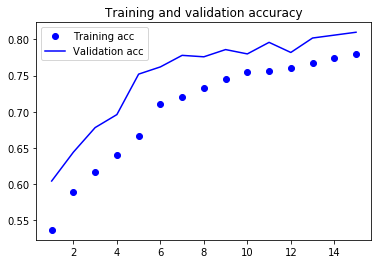

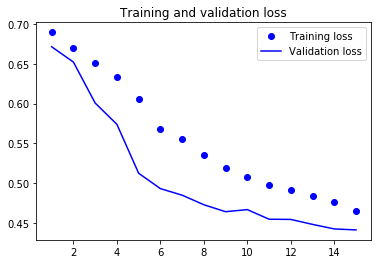

In [13]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [14]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)


In [15]:
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)


In [16]:
model.load_weights('pre_trained_glove_model.h5')
Score, Acc = model.evaluate(x_test, y_test)

25000/25000 [==============================] - 16s 625us/step


In [17]:
print('Test score:', Score)
print('Test accuracy:', Acc)

Test score: 0.4149410544681549
Test accuracy: 0.80844
